In [ ]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3 
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
!pip install top2vec
!pip install umap-learn[plot]

In [1]:
import json
import requests
import numpy as np

import umap
import umap.plot
import hdbscan

from top2vec import Top2Vec
np.random.seed(42)

from konlpy.tag import Mecab
mecab = Mecab()

In [2]:
url = 'http://tools.kinds.or.kr:8888/search/news'

datas = {
    "access_key": "9af2f705-2974-4340-8b55-d69040b944ab",

    "argument": {
        "query": {"title":""},
        "published_at": {
            "from": "2021-08-29",
            "until": "2021-10-06"
            },
            "provider": [],
            "category": ["008004000"],
            "category_incident": [""],
            "byline": "",
            "provider_subject": [""],
            "subject_info": [""],
            "subject_info1": [""],
            "subject_info2": [""],
            "subject_info3": [""],
            "subject_info4": [""],
            "sort": {"date": "asc"},
            "hilight": 200,
            "return_from": 0,
            "return_size": 100000,
            "fields": [
                "byline",
                "category",
                "category_incident",
                "provider_news_id",
                "hilight",
                ]
                }
         }

response = requests.post(url, data=json.dumps(datas))
js=response.json()

js

{'result': 0,
 'return_object': {'documents': [{'byline': '이수영',
    'category': ['경제>유통', 'IT_과학>인터넷_SNS', 'IT_과학>콘텐츠'],
    'category_incident': [],
    'dateline': '2021-08-29T00:25:31.000+09:00',
    'enveloped_at': '2021-08-29T00:16:12.000+09:00',
    'hilight': "산지폐기 위기 딛고 ..'완판 행진'… 온라인마켓, 농산물 유통 새 대안 되나 애호박 가격 폭락으로 화천산 애호박의 산지폐기 소식이 알려졌던 지난달 말,기적 같은 일이 벌어졌다... .. .. ..안타까운 소식에 전국의 소비자들의 주문이 쇄도한 것이다.지난달 25일부터 26일 오전까지 하루 사이에 최소 112t의 애호박 주문이 접수됐다.이는 8㎏ 기준 ..",
    'news_id': '01300101.20210828001612001',
    'provider': '강원도민일보',
    'provider_news_id': '1088846',
    'published_at': '2021-08-29T00:00:00.000+09:00',
    'title': "산지폐기 위기 딛고 '완판 행진'… 온라인마켓, 농산물 유통 새 대안 되나"},
   {'byline': '김경은',
    'category': ['경제>유통', 'IT_과학>콘텐츠', '경제>자동차'],
    'category_incident': [],
    'dateline': '2021-08-29T06:02:00.000+09:00',
    'enveloped_at': '2021-08-29T06:03:02.000+09:00',
    'hilight': '[주간 가구 스토리] 새 매장 열고 새 브랜드 론칭… 업계 ..‘공격 행보’ ..‘나’를 꾸민다는 개념은 얼굴과 몸, 패션을 넘어 실내 인테리어까지 확장하고 있습니다

In [3]:
total_hits = js['return_object']['total_hits']
print("결과 개수:",total_hits)

결과 개수: 9652


In [42]:
#total_hits = 10000
# 모든 타이틀
titles, hilights ,ths, news_ids= [], [], [],[]
for i in range(total_hits):
    title = js['return_object']['documents'][i]['title']
    hilight = js['return_object']['documents'][i]['hilight']
    news_id = js['return_object']['documents'][i]['news_id']
    news_ids.append(news_id)
    th = title +","+ hilight

    #titles.append(title)
    #hilights.append(hilight)
    ths.append(th)
len(ths)

9652

In [43]:
model = 0
model = Top2Vec(documents = ths, tokenizer = mecab.morphs, umap_args = {'n_neighbors': 15, 'n_components': 20, 'metric': 'cosine', "random_state": 42})

2021-10-09 11:26:50,870 - top2vec - INFO - Pre-processing documents for training
2021-10-09 11:26:56,108 - top2vec - INFO - Creating joint document/word embedding
2021-10-09 11:28:58,314 - top2vec - INFO - Creating lower dimension embedding of documents
2021-10-09 11:29:45,252 - top2vec - INFO - Finding dense areas of documents
2021-10-09 11:29:46,294 - top2vec - INFO - Finding topics


In [44]:
# https://github.com/ddangelov/Top2Vec/blob/master/top2vec/Top2Vec.py
# line 360
model._get_document_vectors()

array([[ 0.01168489, -0.04431171,  0.10807437, ..., -0.11171831,
        -0.03911706,  0.00097641],
       [-0.03215925,  0.0175198 ,  0.02002064, ..., -0.06842685,
        -0.10298623,  0.013442  ],
       [ 0.03029217, -0.05798337, -0.07886738, ..., -0.03713411,
         0.00367533,  0.00837709],
       ...,
       [ 0.05129457,  0.04146328,  0.02615085, ...,  0.03467248,
         0.01737152,  0.06893486],
       [-0.0144059 ,  0.02808813, -0.00378053, ...,  0.02172153,
        -0.00025949,  0.01812836],
       [-0.05543713,  0.0218017 , -0.04102441, ...,  0.07752348,
         0.02139907, -0.01130241]], dtype=float32)

In [45]:
umap_args = {'n_neighbors': 15,
             'n_components': 2,
             'metric': 'cosine'}

mapper = umap.UMAP(**umap_args).fit(model._get_document_vectors(norm=False))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


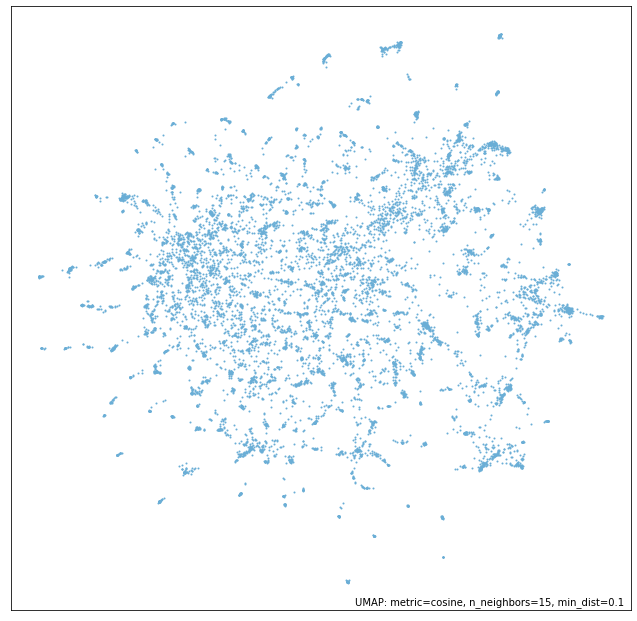

In [46]:
# https://umap-learn.readthedocs.io/en/latest/clustering.html
umap.plot.points(mapper,) 
# color_key {-1:'#000000',0:'#'}

In [47]:
hdbscan_args = {'min_cluster_size': 15,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'}

cluster = hdbscan.HDBSCAN(**hdbscan_args).fit(mapper.embedding_)

In [48]:
cluster.labels_

array([ 24, 153,  49, ...,  -1,  73, 152])

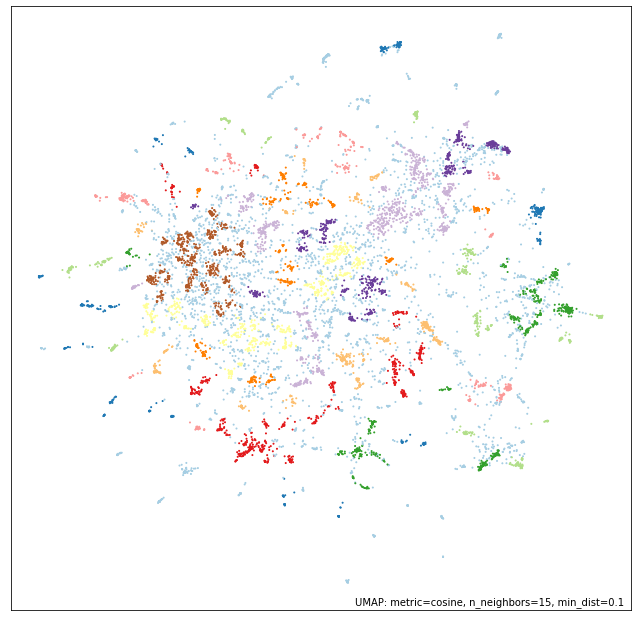

In [49]:
# https://github.com/ddangelov/Top2Vec/blob/master/top2vec/Top2Vec.py
# line 376
#
# https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
umap.plot.points(mapper,cluster.labels_, color_key_cmap='Paired',show_legend=False)

In [50]:
model.get_num_topics()

177

In [51]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [52]:
topic_sizes

array([278, 223, 154, 148, 139, 126, 120, 120, 115, 114, 114, 114, 112,
       111, 108, 101,  93,  93,  92,  89,  86,  86,  85,  83,  80,  80,
        79,  78,  78,  76,  76,  75,  75,  72,  72,  72,  71,  70,  70,
        69,  69,  66,  66,  65,  64,  64,  63,  61,  60,  60,  60,  59,
        59,  59,  59,  59,  58,  58,  58,  57,  57,  56,  56,  55,  55,
        54,  53,  53,  53,  53,  52,  51,  51,  51,  51,  50,  50,  49,
        49,  49,  48,  48,  47,  47,  46,  46,  46,  45,  45,  45,  44,
        44,  43,  43,  42,  42,  42,  42,  41,  41,  40,  40,  39,  39,
        39,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  37,  37,
        37,  37,  36,  36,  36,  35,  35,  35,  35,  34,  34,  34,  33,
        33,  33,  33,  33,  33,  33,  32,  32,  31,  31,  30,  30,  30,
        29,  29,  29,  29,  29,  29,  29,  29,  28,  28,  27,  27,  27,
        27,  26,  26,  26,  26,  25,  25,  25,  25,  24,  24,  24,  24,
        24,  23,  23,  22,  22,  22,  22,  20])

In [53]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=['넷플릭스'], num_topics=4)

In [54]:
topic_nums

array([ 2,  3, 18, 35])

In [55]:
topic_words, word_scores, topic_nums = model.get_topics()

In [57]:
topic_words[2]

array(['플릭스', '패트롤', '83', '순위', '집계', '오징어', '차지', '드라마', '넷플릭스', '오리지널',
       '개국', '인도', '위', '돌풍', '기록', '올랐', '현지', '게임', '오르', '세계', '시리즈',
       'CNN', '일으키', '작품', '황동혁', '기생충', '인기', '미국', '전', '영국', '사로잡',
       '사상', '톱', '이정재', '오른', '동영상', '흥행', '감독', '전날', '우드', 'OTT',
       '서바이벌', '외신', '456', '프랑스', '정호연', '1', '강세', '히트', '달고나'],
      dtype='<U6')

In [59]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=2, num_docs=154)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    if score >= 0.4:
        print(f"Document: {doc_id}, Score: {score}")
        print("-----------")
        print(doc)
        print("-----------")
        print()

Document: 5987, Score: 0.9026285409927368
-----------
'오징어 게임' 한국 드라마 최초 미국 넷플릭스 1위,'오징어 게임' 한국 드라마 최초 미국 넷플릭스 1위 배우 이정재가 주연으로 나선 드라마 ..'오징어 게임'이 한국 작품 최초로 미국 넷플릭스에서 인기 작품 1위를 차지했습니다. .. ..넷플릭스 순위집계 사이트 플릭스 패트롤을 보면 ..'오징어 게임'은 미국에서 1위에 올랐고, 월드 랭킹 TV 쇼 부문에서도 2위를 기록했습니다. .. ..지금까지 한국..
-----------

Document: 5886, Score: 0.8983764052391052
-----------
전세계가 푹 빠졌다…'오징어게임' 美 넷플릭스서 1위,전세계가 푹 빠졌다…'오징어게임' 美 넷플릭스서 1위 넷플릭스 오리지널 시리즈 ..'오징어 게임'이 전세계 넷플릭스 시리즈 인기 순위 2위에 오른 가운데 미국에서는 1위를 기록했다... .. .. .. ..22일 온라인동영상서비스(OTT) 콘텐츠 순위 집계 사이트인 플릭스 패트롤에 따르면 ..'오징어 게임'은 21일 넷플릭스 TV드라마 부문 ..'오늘의..
-----------

Document: 8718, Score: 0.8933187127113342
-----------
'오징어게임' 전 세계 광풍 속 82개국 1위 달성… 인도에서만 2위 기록,'오징어게임' 전 세계 광풍 속 82개국 1위 달성… 인도에서만 2위 기록 넷플릭스 오리지널 시리즈 ..'오징어 게임'이 8일째 넷플릭스 전 세계 TV 프로그램 부문에서 1위를 차지하며 흥행 돌풍을 이어가는 가운데 인도에서만 2위를 차지했다... .. .. ..1일(한국시간) 글로벌 OTT 콘텐츠 순위 집계 사이트인 플릭스 패트롤의 집계에 따르면 ..'..
-----------

Document: 6529, Score: 0.8854166269302368
-----------
'오징어 게임' 한국 드라마 최초 전 세계 넷플릭스 1위,'오징어 게임'